In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [4]:
from pathlib import Path
import torch
import time
import zarr
import re
from pathlib import Path
import nibabel as nib
import numpy  as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import midasmednet.dataset
from midasmednet.dataset import GridPatchSampler
from midasmednet.prediction import test_model
from midasmednet.utils.export import export_zarr_to_nifti, export_results_to_zarr, copy_affines
import logging
import midastools.visualization.nora as nora
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
logging.basicConfig(level=logging.DEBUG)

### Grid sampler handling

In [379]:
# todo check
zarr_path = '/mnt/share/raheppt1/data/aortath/interim/zarr/training_mra_preprocessed.zarr'
subject_keys = ['100000', '100001', '100002']
ds = GridPatchSampler(zarr_path,
                      subject_keys,
                      [100,100,100], [20,20,20],
                      image_group='images_norm',
                      out_channels=1)

patch_loader = DataLoader(ds, batch_size=4)

t = time.perf_counter()
for patch in patch_loader:
    print(patch['subject_key'][0], str(int(patch['count'][0])).zfill(6), patch['data'][0].shape)
    
    # process batch of patches ....
    
    # aggregate processed patches 
    ds.add_processed_batch(patch)
    
    new_t = time.perf_counter()
    print(f'{new_t - t: .3f}s')
    t = new_t

100000 000000 torch.Size([1, 100, 100, 100])
 1.432s
100000 000004 torch.Size([1, 100, 100, 100])
 0.035s
100000 000008 torch.Size([1, 100, 100, 100])
 0.036s
100000 000012 torch.Size([1, 100, 100, 100])
 0.081s
100000 000016 torch.Size([1, 100, 100, 100])
 0.053s
100000 000020 torch.Size([1, 100, 100, 100])
 0.029s
100000 000024 torch.Size([1, 100, 100, 100])
 0.019s
100000 000028 torch.Size([1, 100, 100, 100])
 0.018s
100000 000032 torch.Size([1, 100, 100, 100])
 0.016s
100000 000036 torch.Size([1, 100, 100, 100])
 0.019s
100000 000040 torch.Size([1, 100, 100, 100])
 0.024s
100000 000044 torch.Size([1, 100, 100, 100])
 0.020s
100000 000048 torch.Size([1, 100, 100, 100])
 0.014s
100000 000052 torch.Size([1, 100, 100, 100])
 0.019s
100000 000056 torch.Size([1, 100, 100, 100])
 0.014s
100001 000000 torch.Size([1, 100, 100, 100])
 0.477s
100001 000004 torch.Size([1, 100, 100, 100])
 0.050s
100001 000008 torch.Size([1, 100, 100, 100])
 0.016s
100001 000012 torch.Size([1, 100, 100, 100])
 

### Predicting segmentation masks

In [6]:
# full dataset
#zarr_path = '/mnt/share/raheppt1/data/aortath/interim/zarr/full_1_5_mm_LAS_preprocessed.zarr/'
#with zarr.open(zarr_path, 'r') as zf:
#    subject_keys = [k for k in zf['images_norm']]
#print(subject_keys[:3])

# validation dataset
zarr_path = '/mnt/share/raheppt1/data/aortath/interim/zarr/training_1_5_mm_LAS_preprocessed.zarr/'
subject_key_file = '/mnt/share/raheppt1/data/aortath/interim/crossval/validation.dat'
with open(subject_key_file, 'r') as f:
    subject_keys = f.readlines()
    subject_keys = [k.strip() for k in subject_keys]
    
# select subject key subgroup
selected_subject_keys = subject_keys
selected_subject_keys

['100080',
 '100081',
 '100082',
 '100083',
 '100084',
 '100085',
 '100086',
 '100087',
 '100088',
 '100089',
 '100090',
 '100091',
 '100092',
 '100093',
 '100094',
 '100095',
 '100096',
 '100097',
 '100098',
 '100099']

In [7]:
model_path = '/mnt/share/raheppt1/data/aortath/processed/models/aorta_segmentation16_200413_135229_model.pt'
results = test_model(input_data_path=zarr_path,
                input_group='images_norm',
                model_path=model_path,
                subject_keys=selected_subject_keys,
                patch_size=[96,96,96], 
                patch_overlap=[15,15,15],
                batch_size=4,
                out_channels=2,
                in_channels=1,
                fmaps=64,
                num_workers=0,
                one_hot_encoded=False,
                data_reader=midasmednet.dataset.read_zarr)

INFO:midasmednet.prediction:using cuda:0
INFO:midasmednet.prediction:creating U-net model (inputs 1, outputs 2)
INFO:midasmednet.prediction:restoring model, epoch: 32
INFO:midasmednet.prediction:inference ...
DEBUG:midasmednet.dataset:loading images_norm/100080
DEBUG:midasmednet.dataset:loading images_norm/100081
DEBUG:midasmednet.dataset:loading images_norm/100082
DEBUG:midasmednet.dataset:loading images_norm/100083
DEBUG:midasmednet.dataset:loading images_norm/100084
DEBUG:midasmednet.dataset:loading images_norm/100085
DEBUG:midasmednet.dataset:loading images_norm/100086
DEBUG:midasmednet.dataset:loading images_norm/100087
DEBUG:midasmednet.dataset:loading images_norm/100088
DEBUG:midasmednet.dataset:loading images_norm/100089
DEBUG:midasmednet.dataset:loading images_norm/100090
DEBUG:midasmednet.dataset:loading images_norm/100091
DEBUG:midasmednet.dataset:loading images_norm/100092
DEBUG:midasmednet.dataset:loading images_norm/100093
DEBUG:midasmednet.dataset:loading images_norm/100

<IPython.core.display.Javascript object>


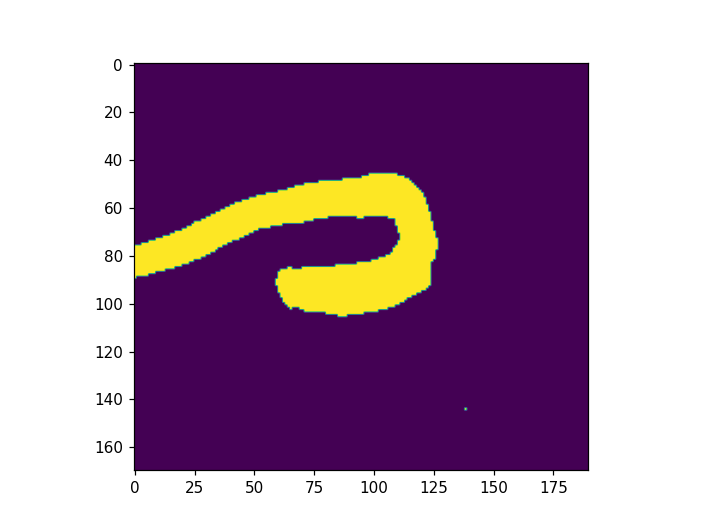

In [32]:
plt.figure()
plt.imshow(np.max(results['100099'][0,...].astype(np.float32), axis=0))

In [35]:
# export results to zarr file
zarr_export_path = '/mnt/share/raheppt1/data/aortath/processed/predictions/zarr/training_1_5_mm_LAS_predictions.zarr'
export_results_to_zarr(zarr_export_path,
                       results,
                       group='label_predictions',
                       subject_keys=selected_subject_keys,
                       dtype=np.uint8)

DEBUG:midasmednet.utils.export:exporting 100080, shape (1, 250, 170, 190), type uint8
DEBUG:midasmednet.utils.export:exporting 100081, shape (1, 250, 170, 190), type uint8
DEBUG:midasmednet.utils.export:exporting 100082, shape (1, 250, 170, 190), type uint8
DEBUG:midasmednet.utils.export:exporting 100083, shape (1, 250, 170, 190), type uint8
DEBUG:midasmednet.utils.export:exporting 100084, shape (1, 250, 170, 190), type uint8
DEBUG:midasmednet.utils.export:exporting 100085, shape (1, 250, 170, 190), type uint8
DEBUG:midasmednet.utils.export:exporting 100086, shape (1, 250, 170, 190), type uint8
DEBUG:midasmednet.utils.export:exporting 100087, shape (1, 250, 170, 190), type uint8
DEBUG:midasmednet.utils.export:exporting 100088, shape (1, 250, 170, 190), type uint8
DEBUG:midasmednet.utils.export:exporting 100089, shape (1, 250, 170, 190), type uint8
DEBUG:midasmednet.utils.export:exporting 100090, shape (1, 250, 170, 190), type uint8
DEBUG:midasmednet.utils.export:exporting 100091, shape

In [36]:
# export to nifti (heatmaps)
out_dir = '/mnt/share/raheppt1/data/aortath/processed/predictions/nifti/validation/'
export_zarr_to_nifti(zarr_export_path,
                     out_dir,
                     group='label_predictions',
                     subject_keys=selected_subject_keys,
                     dtype=np.uint8)

DEBUG:midasmednet.utils.export:subject 100080, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100081, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100082, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100083, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100084, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100085, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100086, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100087, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100088, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100089, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100090, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100091, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100092, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100093, shape (1, 250, 17

### Predicting landmarks

In [65]:
# full dataset
#zarr_path = '/mnt/share/raheppt1/data/aortath/interim/zarr/full_1_5_mm_LAS_preprocessed.zarr/'
#with zarr.open(zarr_path, 'r') as zf:
#    subject_keys = [k for k in zf['images_norm']]
#print(subject_keys[:3])

# validation dataset
zarr_path = '/mnt/share/raheppt1/data/aortath/interim/zarr/training_1_5_mm_LAS_preprocessed.zarr/'
subject_key_file = '/mnt/share/raheppt1/data/aortath/interim/crossval/validation.dat'
with open(subject_key_file, 'r') as f:
    subject_keys = f.readlines()
    subject_keys = [k.strip() for k in subject_keys]
    
# select subject key subgroup
selected_subject_keys = subject_keys
selected_subject_keys

['100080',
 '100081',
 '100082',
 '100083',
 '100084',
 '100085',
 '100086',
 '100087',
 '100088',
 '100089',
 '100090',
 '100091',
 '100092',
 '100093',
 '100094',
 '100095',
 '100096',
 '100097',
 '100098',
 '100099']

In [66]:
# predicting heatmaps
model_path = '/mnt/share/raheppt1/data/aortath/processed/models/aorta_landmarks13_200411_232644_model.pt'
results = test_model(input_data_path=zarr_path,
                input_group='images_norm',
                model_path=model_path,
                subject_keys=selected_subject_keys,
                patch_size=[96,96,96], 
                patch_overlap=[15,15,15],
                batch_size=4,
                out_channels=6,
                in_channels=1,
                fmaps=64,
                num_workers=0,
                one_hot_encoded=True,
                softmax_output=False,
                data_reader=midasmednet.dataset.read_zarr)

INFO:midasmednet.prediction:using cuda:0
INFO:midasmednet.prediction:creating U-net model (inputs 1, outputs 6)
INFO:midasmednet.prediction:restoring model, epoch: 35
INFO:midasmednet.prediction:inference ...
DEBUG:midasmednet.dataset:loading images_norm/100080
DEBUG:midasmednet.dataset:loading images_norm/100081
DEBUG:midasmednet.dataset:loading images_norm/100082
DEBUG:midasmednet.dataset:loading images_norm/100083
DEBUG:midasmednet.dataset:loading images_norm/100084
DEBUG:midasmednet.dataset:loading images_norm/100085
DEBUG:midasmednet.dataset:loading images_norm/100086
DEBUG:midasmednet.dataset:loading images_norm/100087
DEBUG:midasmednet.dataset:loading images_norm/100088
DEBUG:midasmednet.dataset:loading images_norm/100089
DEBUG:midasmednet.dataset:loading images_norm/100090
DEBUG:midasmednet.dataset:loading images_norm/100091
DEBUG:midasmednet.dataset:loading images_norm/100092
DEBUG:midasmednet.dataset:loading images_norm/100093
DEBUG:midasmednet.dataset:loading images_norm/100

In [68]:
results['100099'].dtype

dtype('float16')

<IPython.core.display.Javascript object>


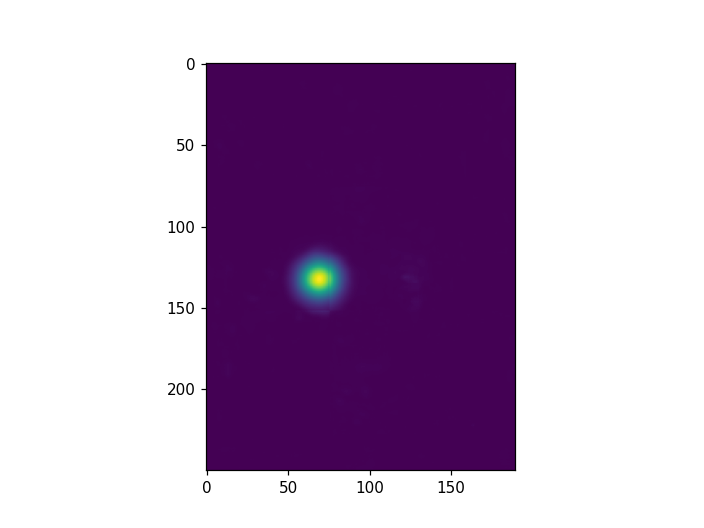

In [69]:
plt.figure()
plt.imshow(np.max(results['100099'][0, ...].astype(np.float32), axis=1))

In [70]:
# export results to zarr file
zarr_export_path = '/mnt/share/raheppt1/data/aortath/processed/predictions/zarr/training_1_5_mm_LAS_predictions.zarr'
export_results_to_zarr(zarr_export_path,
                       results,
                       group='heatmap_predictions',
                       subject_keys=selected_subject_keys,
                       dtype=np.float16)

# copy affine transformation matrices to export zarr file
# copy_affines(zarr_path, zarr_export_path)

DEBUG:midasmednet.utils.export:exporting 100080, shape (6, 250, 170, 190), type float16
DEBUG:midasmednet.utils.export:exporting 100081, shape (6, 250, 170, 190), type float16
DEBUG:midasmednet.utils.export:exporting 100082, shape (6, 250, 170, 190), type float16
DEBUG:midasmednet.utils.export:exporting 100083, shape (6, 250, 170, 190), type float16
DEBUG:midasmednet.utils.export:exporting 100084, shape (6, 250, 170, 190), type float16
DEBUG:midasmednet.utils.export:exporting 100085, shape (6, 250, 170, 190), type float16
DEBUG:midasmednet.utils.export:exporting 100086, shape (6, 250, 170, 190), type float16
DEBUG:midasmednet.utils.export:exporting 100087, shape (6, 250, 170, 190), type float16
DEBUG:midasmednet.utils.export:exporting 100088, shape (6, 250, 170, 190), type float16
DEBUG:midasmednet.utils.export:exporting 100089, shape (6, 250, 170, 190), type float16
DEBUG:midasmednet.utils.export:exporting 100090, shape (6, 250, 170, 190), type float16
DEBUG:midasmednet.utils.export:e

<IPython.core.display.Javascript object>


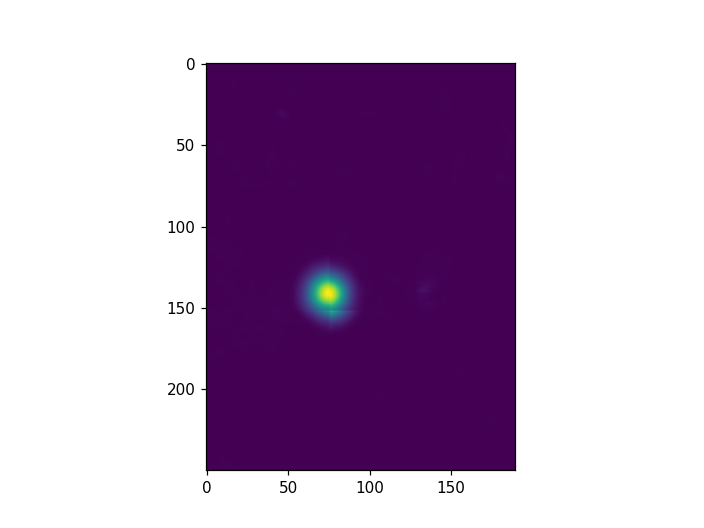

In [61]:
with zarr.open(zarr_export_path, 'r') as source:
    test_ds = source['heatmap_predictions/100080'][:]
test_ds.shape
plt.figure()
plt.imshow(np.max(test_ds[0,...].astype(np.float32), axis=1))

In [71]:
# export to nifti (heatmaps)
out_dir = '/mnt/share/raheppt1/data/aortath/processed/predictions/nifti/validation/'
export_zarr_to_nifti(zarr_export_path,
                     out_dir,
                     group='heatmap_predictions',
                     subject_keys=selected_subject_keys,
                     dtype=np.float32)

DEBUG:midasmednet.utils.export:subject 100080, shape (6, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100081, shape (6, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100082, shape (6, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100083, shape (6, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100084, shape (6, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100085, shape (6, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100086, shape (6, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100087, shape (6, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100088, shape (6, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100089, shape (6, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100090, shape (6, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100091, shape (6, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100092, shape (6, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100093, shape (6, 250, 17

In [72]:
# export to nifti (images)
out_dir = '/mnt/share/raheppt1/data/aortath/processed/predictions/nifti/validation/'
export_zarr_to_nifti(zarr_path,
                     out_dir,
                     group='images_norm',
                     subject_keys=selected_subject_keys,
                     dtype=np.float32)

DEBUG:midasmednet.utils.export:subject 100080, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100081, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100082, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100083, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100084, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100085, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100086, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100087, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100088, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100089, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100090, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100091, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100092, shape (1, 250, 170, 190)
DEBUG:midasmednet.utils.export:subject 100093, shape (1, 250, 17

In [10]:
# copy nifis to nora project
out_dir = Path('/mnt/share/raheppt1/data/aortath/processed/predictions/nifti/validation/')
for f in out_dir.glob('*.nii.gz'):
    subj_id = re.match('([0-9]{6}).*.nii.gz', f.name).group(1)
    nora.add_to_project(f, project='NAKO1004AORTV', subject_id='noname_noname_'+subj_id, study_id=subj_id)

b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
b'Finished adding 1 files         \r\n'
